In [597]:
using Plots
using GynC
using GynC: sample, hzobj, Config, Lausanne

thin=10
K=10000
M=5
niter=100;

100

In [ ]:
@time ss=[sample(Config(Lausanne(m), thin=thin), K) for m in 1:M];

In [599]:
@time pi1=WeightedChain(ss);
@show length(pi1.weights)

  5.124199 seconds (65.77 M allocations: 1.024 GB, 17.34% gc time)
length(pi1.weights) = 31


31

In [600]:
pin=deepcopy(pi1);
@time for i in 1:niter
    emiteration!(pin)
end

  0.000286 seconds (301 allocations: 17.219 KB)


In [601]:
samples = pi1.samples
w0      = pi1.weights
hz=hzobj(samples, map(GynC.data, ss))

(::#78) (generic function with 1 method)

In [608]:
hz(pi1.weights)

-130.48297253094773

In [602]:
using ForwardDiff

function gradify(f, x)
  out=GradientResult(x)
  function df(x)
    ForwardDiff.gradient!(out, f, x)
    ForwardDiff.value(out), ForwardDiff.gradient(out)
  end
end

Dhz = gradify(hz, w0);

In [603]:
using BenchmarkTools
@show @benchmark hz(w0)
@show @benchmark Dhz(w0);

@benchmark(hz(w0)) = BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     4
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  2.20 kb
  allocs estimate:  55
  minimum time:     6.91 μs (0.00% GC)
  median time:      7.58 μs (0.00% GC)
  mean time:        8.94 μs (7.30% GC)
  maximum time:     2.68 ms (98.86% GC)
@benchmark(Dhz(w0)) = BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  31.72 kb
  allocs estimate:  47
  minimum time:     105.41 μs (0.00% GC)
  median time:      112.25 μs (0.00% GC)
  mean time:        128.11 μs (6.63% GC)
  maximum time:     9.21 ms (96.59% GC)


In [604]:
function pseudoeuler(f, w; h=1, project=projectscale)
    Df=gradify(f, w)
    f,df = Df(w)
    project(w+h*df)
end

projectscale(w) = w/sum(w)

projectscale (generic function with 1 method)


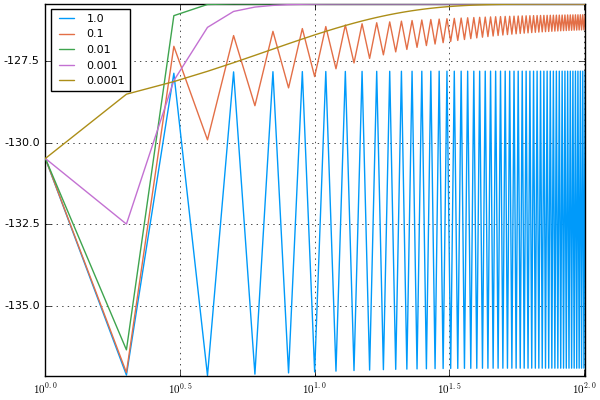

In [605]:
p=plot(xaxis=:log)
for h=[1, 0.1, 0.01, 0.001, 0.0001]
  global wn=w0
  hzs=[hz(wn)]
  for i=1:niter
      wn = pseudoeuler(hz, wn, h=h)
      push!(hzs, hz(wn))
  end
  plot!(p,hzs, label=h)
end
p

In [607]:
wn, hz(wn)

([0.0509655,0.0137558,0.036112,0.0382544,0.0216663,0.0166227,0.0301548,0.0253556,0.0167736,0.0206569  …  0.0288888,0.0157245,0.0502813,0.0542696,0.02982,0.0419082,0.0217157,0.0382818,0.0268928,0.0532474],-125.75711196699423)

In [612]:
KernelDensity.kde(pi1.samples[:,8], weights=wn)

LoadError: LoadError: MethodError: no method matching kde(::Array{Float64,1}; weights=[0.0509655,0.0137558,0.036112,0.0382544,0.0216663,0.0166227,0.0301548,0.0253556,0.0167736,0.0206569  …  0.0288888,0.0157245,0.0502813,0.0542696,0.02982,0.0419082,0.0217157,0.0382818,0.0268928,0.0532474])
Closest candidates are:
  kde(::AbstractArray{T<:Real,1}; npoints, bandwidth, kernel, boundary) at /home/numerik/bzfsikor/.julia/v0.5/KernelDensity/src/univariate.jl:143 got unsupported keyword argument "weights"
  kde(::AbstractArray{T<:Real,1}, !Matched::Range{T}; bandwidth, kernel) at /home/numerik/bzfsikor/.julia/v0.5/KernelDensity/src/univariate.jl:136 got unsupported keyword argument "weights"
  kde(::AbstractArray{T<:Real,1}, !Matched::Range{T}, !Matched::Distributions.Distribution{Distributions.Univariate,S<:Distributions.ValueSupport}) at /home/numerik/bzfsikor/.julia/v0.5/KernelDensity/src/univariate.jl:123 got unsupported keyword argument "weights"
  ...
while loading In[612], in expression starting on line 1


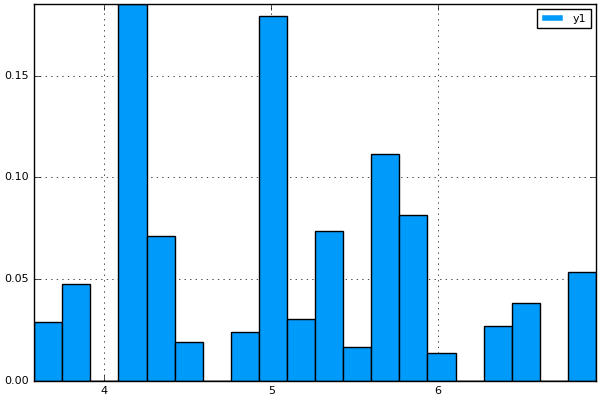

In [618]:
wh = GynC.weightedhist(pi1.samples[:,8], wn, 20)
bar(wh...)